# Tracking a 2d point spiraling in the plane using the Kalman filter

We use the [dynamax](https://github.com/probml/dynamax/blob/main/dynamax/) library.

This example demonstrates the use of the lgssm filtering and smoothing when
the linear dynamical system induced by the matrix F has imaginary eigenvalues.

In [10]:
try:
    import dynamax
except ModuleNotFoundError:
    print("installing dynamax")
    %pip install -qq git+https://github.com/probml/dynamax.git
    import dynamax

from dynamax.linear_gaussian_ssm.models.linear_gaussian_ssm import LinearGaussianSSM
from dynamax.plotting import plot_uncertainty_ellipses

In [13]:
from jax import numpy as jnp
from jax import random as jr
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# Silence WARNING:root:The use of `check_types` is deprecated and does not have any effect.
# https://github.com/tensorflow/probability/issues/1523
import logging

logger = logging.getLogger()


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

In [15]:
delta = 1

F = np.array([[0.1, 1.1, delta, 0], [-1, 1, 0, delta], [0, 0, 0.1, 0], [0, 0, 0, 0.1]])

evals, evec = np.linalg.eig(F)
print(evals)
print(evec)

[0.55+0.94736477j 0.55-0.94736477j 0.1 +0.j         0.1 +0.j        ]
[[ 7.23746864e-01+0.j          7.23746864e-01-0.j
  -5.17891804e-01+0.j          7.07106781e-01+0.j        ]
 [ 2.96078263e-01+0.62332025j  2.96078263e-01-0.62332025j
  -5.75435338e-01+0.j         -1.02393756e-16+0.j        ]
 [ 0.00000000e+00+0.j          0.00000000e+00-0.j
   6.32978871e-01+0.j          0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j          0.00000000e+00-0.j
   0.00000000e+00+0.j          7.07106781e-01+0.j        ]]


In [18]:
def kf_spiral():
    state_dim = 4
    emission_dim = 2
    delta = 1.0
    F = np.array([[0.1, 1.1, delta, 0], [-1, 1, 0, delta], [0, 0, 0.1, 0], [0, 0, 0, 0.1]])

    lgssm = LinearGaussianSSM(state_dim, emission_dim)
    params, _ = lgssm.random_initialization(jr.PRNGKey(0))
    params["initial"]["mean"] = jnp.array([8.0, 10.0, 1.0, 0.0])
    params["initial"]["cov"] = jnp.eye(state_dim) * 0.1
    params["dynamics"]["weights"] = F
    params["dynamics"]["cov"] = jnp.eye(state_dim) * 0.001
    params["emissions"]["weights"] = jnp.array([[1.0, 0, 0, 0], [0, 1.0, 0, 0]])
    params["emissions"]["cov"] = jnp.eye(emission_dim) * 5.0

    num_timesteps = 15
    key = jr.PRNGKey(310)
    x, y = lgssm.sample(params, key, num_timesteps)
    lgssm_posterior = lgssm.smoother(params, y)
    return x, y, lgssm_posterior

In [4]:
def plot_lgssm_posterior(post_means, post_covs, ax=None, ellipse_kwargs={}, legend_kwargs={}, **kwargs):
    """Plot posterior means and covariances for the first two dimensions of
     the latent state of a LGSSM.
    Args:
        post_means: array(T, D).
        post_covs: array(T, D, D).
        ax: matplotlib axis.
        ellipse_kwargs: keyword arguments passed to matplotlib.patches.Ellipse().
        **kwargs: passed to ax.plot().
    """
    if ax is None:
        fig, ax = plt.subplots()

    # This is to stop some weird behaviour where running the function multiple
    # #  times with an empty argument wouldn't reset the dictionary.
    # if ellipse_kwargs is None:
    #     ellipse_kwargs = dict()

    # if 'edgecolor' not in ellipse_kwargs:
    #     if 'color' in kwargs:
    #         ellipse_kwargs['edgecolor'] = kwargs['color']

    # Select the first two dimensions of the latent space.
    post_means = post_means[:, :2]
    post_covs = post_covs[:, :2, :2]

    # Plot the mean trajectory
    ax.plot(post_means[:, 0], post_means[:, 1], **kwargs)
    # Plot covariance at each time point.
    plot_uncertainty_ellipses(post_means, post_covs, ax, **ellipse_kwargs)

    ax.axis("equal")

    if "label" in kwargs:
        ax.legend(**legend_kwargs)

    return

In [5]:
def plot_kf_spiral(x, y, lgssm_posterior):
    dict_figures = {}
    fig, ax = plt.subplots()
    ax.plot(*x[:, :2].T, ls="--", color="darkgrey", marker="o", markersize=5, label="true state")
    dict_figures["spiral_data"] = fig

    fig, ax = plt.subplots()
    ax.plot(*x[:, :2].T, ls="--", color="darkgrey", marker="o", markersize=5, label="true state")
    plot_lgssm_posterior(
        lgssm_posterior.filtered_means,
        lgssm_posterior.filtered_covariances,
        ax=ax,
        color="tab:red",
        label="filtered",
        ellipse_kwargs={"linewidth": 0.5},
    )
    dict_figures["spiral_filtered"] = fig

    fig, ax = plt.subplots()
    ax.plot(*x[:, :2].T, ls="--", color="darkgrey", marker="o", markersize=5, label="true state")
    plot_lgssm_posterior(
        lgssm_posterior.smoothed_means,
        lgssm_posterior.smoothed_covariances,
        ax=ax,
        color="tab:red",
        label="smoothed",
        ellipse_kwargs={"linewidth": 0.5},
    )
    dict_figures["spiral_smoothed"] = fig
    return dict_figures

spiral_data.pdf
spiral_filtered.pdf
spiral_smoothed.pdf


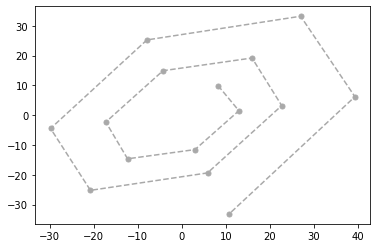

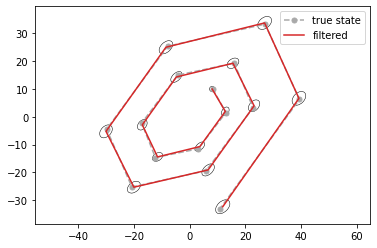

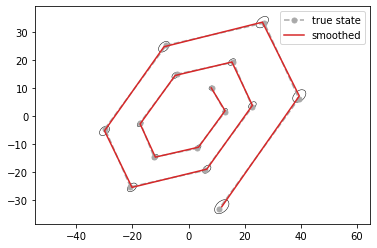

In [19]:
x, y, lgssm_posterior = kf_spiral()

dict_figures = plot_kf_spiral(x, y, lgssm_posterior)

for k, v in dict_figures.items():
    fname = k + ".pdf"
    print(fname)
    fig = v
    # fig.savefig(fname)